In [1]:
import copy
import numpy as np
import pandas as pd
import scanpy as sc
from MarkerCount.marker_count import MarkerCount_Ref, MarkerCount

import plotly.graph_objects as go
def plot_sankey( source, target, title = 'Title', fs = 12 ):
    
    src_lst = list(set(source))
    tgt_lst = list(set(target))
    src_lst.sort()
    tgt_lst.sort()

    src = []
    tgt = []
    val = []
    sl_lst = []
    tl_lst = []
    Ns = len((src_lst))
    for k, s in enumerate(src_lst):
        bs = source == s
        for m, t in enumerate(tgt_lst):
            bt = target == t
            b = bs & bt
            if np.sum(b) > 0:
                if s not in sl_lst:
                    sn = len(sl_lst)
                    sl_lst.append(s)
                else:
                    for n, lbl in enumerate(sl_lst):
                        if s == lbl:
                            sn = n
                            break

                if t not in tl_lst:
                    tn = len(tl_lst) + Ns
                    tl_lst.append(t)
                else:
                    for n, lbl in enumerate(tl_lst):
                        if t == lbl:
                            tn = n + Ns
                            break

                src.append(sn)
                tgt.append(tn)
                val.append(np.sum(b))
                label_lst = sl_lst + tl_lst

    label = list(set(src+tgt))

    link = dict(source = src, target = tgt, value = val)
    node = dict(label = label_lst, pad=50, thickness=5)
    data = go.Sankey(link = link, node=node)
    # plot
    fig = go.Figure(data)
    fig.show()


## Reference based MarkerCount
#### Load data

In [11]:
file_test = 'Melanoma_5K.h5ad'
file_ref = 'HeadNeck_6K.h5ad'

adata_ref = sc.read_h5ad(file_ref)
adata_test = sc.read_h5ad(file_test)

#### Set data to pass to MarkerCount

In [12]:
## Variables to pass to the MkrCnt_Ref
X_ref = adata_ref.to_df() # rows: cell, cols: genes
cell_type_ref = adata_ref.obs['broad_cell_type']
X_test = adata_test.to_df() # rows: cell, cols: genes

## This is for comparison with the predicted cell type
cell_type_test = adata_test.obs['broad_cell_type']

In [13]:
## Check cell types in the reference
set(cell_type_ref), set(cell_type_test)

({'B cell',
  'Dendritic cell',
  'Endothelial cell',
  'Fibroblast',
  'Macrophage',
  'Mast cell',
  'Myocyte',
  'T cell',
  'Tumor',
  'Unknown'},
 {'B cell',
  'Endothelial cell',
  'Fibroblast',
  'Macrophage',
  'NK cell',
  'T cell',
  'Tumor',
  'Unknown'})

#### Run MarkerCount

In [14]:
## If you don't want to exclude some cell types, e.g., 'Unknown's
cells_to_exclude = ['Unknown', 'Tumor']

df_res = MarkerCount_Ref( X_ref, cell_type_ref, X_test, \
                          cell_types_to_excl = cells_to_exclude, \
                          log_transformed = False, \
                          file_to_save_marker = 'my_markers', \
                          verbose = True )

## The identification results are in df_res['cell_type_pred']
adata_test.obs['cell_type_pred'] = df_res['cell_type_pred']

MarkerCount-Ref running ..  
Ref. has 23686 genes, Test data has 23684 genes -> Num. common 23682
N_markers: 18(Dendritic cell), 19(Macrophage), 19(Endothelial cell), 33(Myocyte), 18(T cell), 18(Fibroblast), 18(Mast cell), 18(B cell), 
N_cells_per_cluster: max, median, min = 330, 120, 25 with 33(4513) clusters(cells)
MarkerCount-Ref processing done.


In [15]:
## Check the markers found using the reference annotation
df_mkr_lst = pd.read_csv('my_markers_list.csv', index_col = 0)
df_mkr_lst

,cell_type,marker_gene,occ_freq_target,occ_freq_non_target
0,Dendritic cell,FLT3,0.882353,0.027792
1,Dendritic cell,CCL22,0.666667,0.041521
2,Dendritic cell,KIF2A,0.784314,0.088966
3,Dendritic cell,LAMP3,1.000000,0.086972
4,Dendritic cell,TRAF1,0.725490,0.058486
...,...,...,...,...
156,B cell,ANKRD28,0.724638,0.160336
157,B cell,SLAMF7,0.768116,0.097983
158,B cell,ST6GAL1,0.760870,0.172219
159,B cell,FAM46C,0.949275,0.219431


In [16]:
## Check the marker matrix found using the reference annotation
df_mkr_lst = pd.read_csv('my_markers_matrix.csv', index_col = 0)
df_mkr_lst

,DERL3,S1PR1,C1S,MYOT,FYB,SERPINA1,GNG11,ECSCR,KIT,MYL1,...,ADRBK2,FYN,DSG3,IRF4,ARHGAP10,TBC1D4,ELK2AP,LCK,CD3D,TRIM29
Dendritic cell,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,0,0,0
Macrophage,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Endothelial cell,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Myocyte,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
T cell,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
Fibroblast,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mast cell,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
B cell,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Check results - sankey diagram

In [17]:
plot_sankey( cell_type_test, df_res['cell_type_pred'] )

In [18]:
b = cell_type_test == df_res['cell_type_pred']
np.sum(b), len(b)

(2722, 4513)

#### Check results - umap/tsne plot

computing PCA
    with n_comps=15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


... storing 'cell_type_pred' as categorical


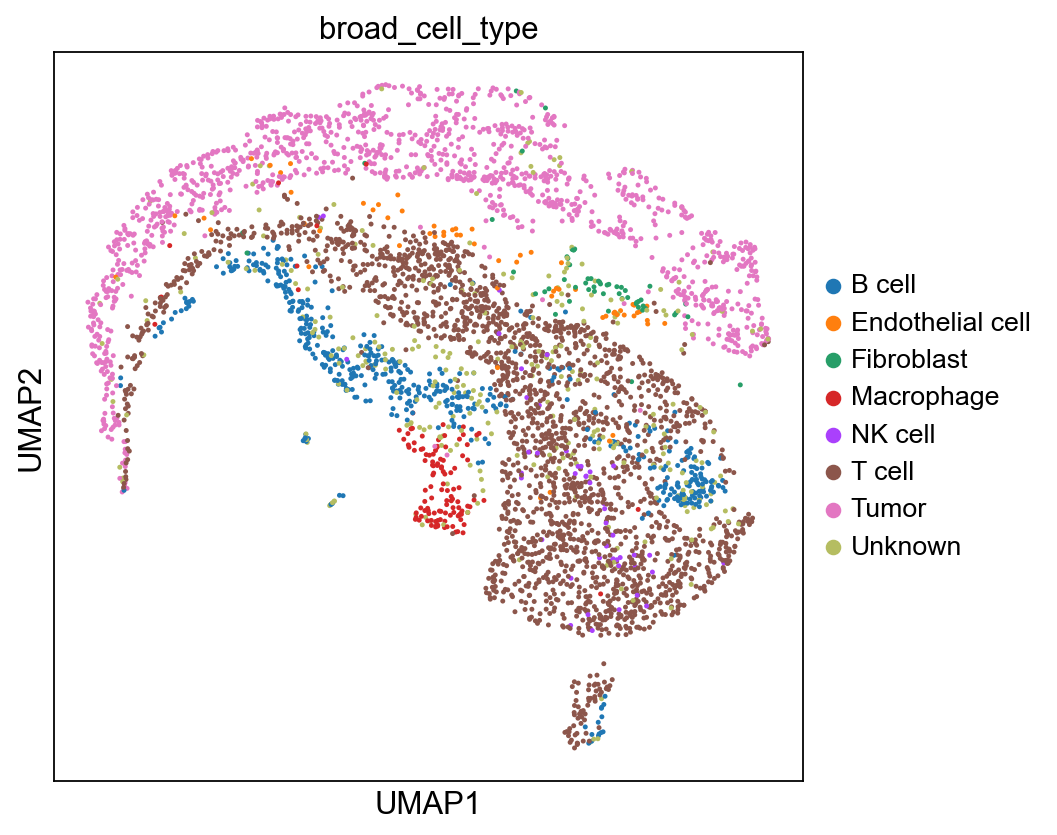

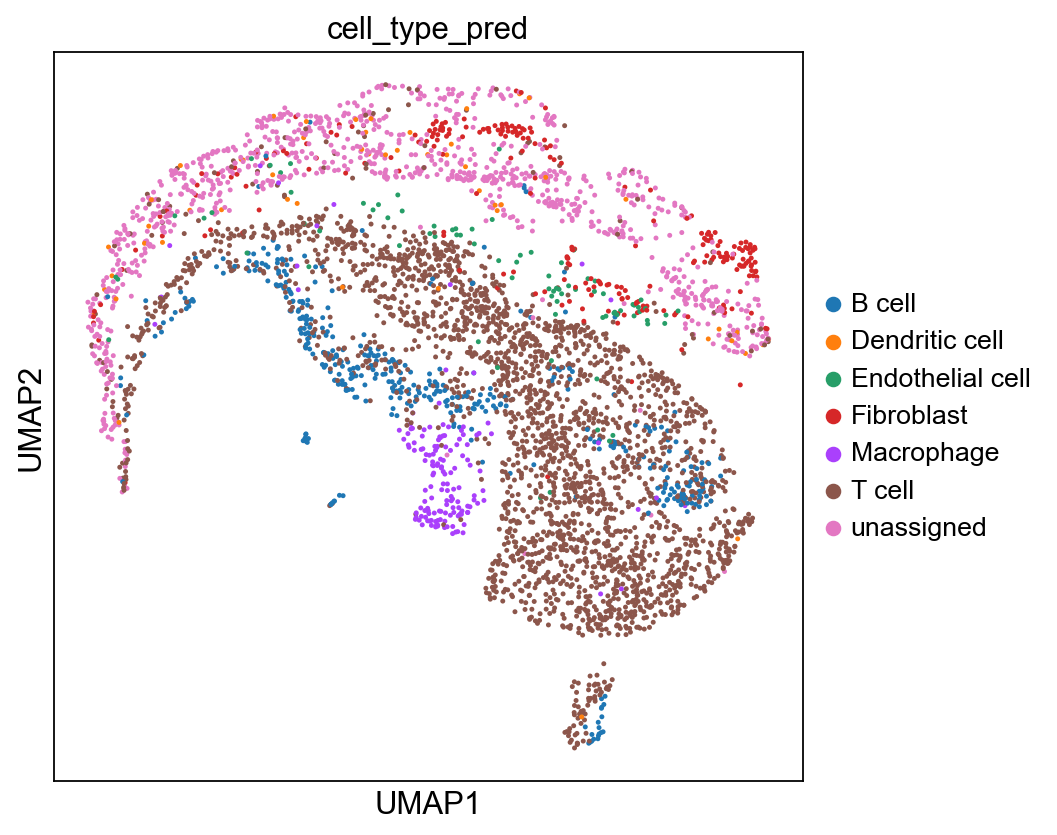

In [19]:
#PCA
N_pca = 15
sc.tl.pca(adata_test, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(adata_test, n_neighbors=10, n_pcs=N_pca)
sc.tl.umap(adata_test)

sc.settings.verbosity = 3
sc.settings.set_figure_params(figsize=(6, 6), dpi=80, facecolor='white')

sc.pl.umap(adata_test, color=['broad_cell_type'], s = 20, legend_fontsize = 12)
sc.pl.umap(adata_test, color=['cell_type_pred'], s = 20, legend_fontsize = 12)

## Marker-based MarkerCount
#### Load data

In [20]:
file_test = 'Headneck_8K.h5ad'
file_test = 'Melanoma_5K.h5ad'
adata_test = sc.read_h5ad(file_test)

## Variables to pass to the MkrCnt_Ref
X_test = adata_test.to_df() # rows: cell, cols: genes

## This is for comparison with the predicted cell type
cell_type_test = adata_test.obs['broad_cell_type']

#### Load marker matrix  (preprocessed)

In [21]:
file_marker_matrix = 'Mkr_mat_CellMarker_Blood.csv'
df_mkr_mat = pd.read_csv(file_marker_matrix, index_col = 0)

#### Run MarkerCount

In [22]:
df_res = MarkerCount( X_test, df_mkr_mat, \
                      log_transformed = False, verbose = True )

## The identification results are stored in df_res['cell_type_pred']
adata_test.obs['cell_type_pred'] = df_res['cell_type_pred']    

MarkerCount running ..  
N_cells_per_cluster: max, median, min = 375, 120, 28 with 33(4513) clusters(cells)
N_markers: 18(Effector CD8+ memory T (Tem) cell), 4(Fibroblast), 4(Naive T cell), 48(Regulatory T (Treg) cell), 3(CD4+ memory T cell), 3(Megakaryocyte), 4(CD8+ T cell), 18(Naive CD4+ T cell), 101(CD141+CLEC9A+ dendritic cell), 3(Monocyte derived dendritic cell), 31(CD1C+_A dendritic cell), 18(Naive CD8+ T cell), 4(CD4+ T cell), 6(B cell), 3(Megakaryocyte progenitor cell), 1(pro-Natural killer cell (pro-NK cell)), 55(CD1C+_B dendritic cell), 3(Natural killer T (NKT) cell), 5(CD14+CD16+ monocyte), 14(Natural killer cell), 3(Dendritic cell), 2(Myeloid cell), 18(Plasmacytoid dendritic cell), 315(CD1C-CD141- dendritic cell), 3(Endothelial cell), 5(T cell), 5(Macrophage), 80(AXL+SIGLEC6+ dendritic cell), 
MarkerCount processing done.


In [23]:
plot_sankey( cell_type_test, df_res['cell_type_pred'] )

computing PCA
    with n_comps=15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


... storing 'cell_type_pred' as categorical


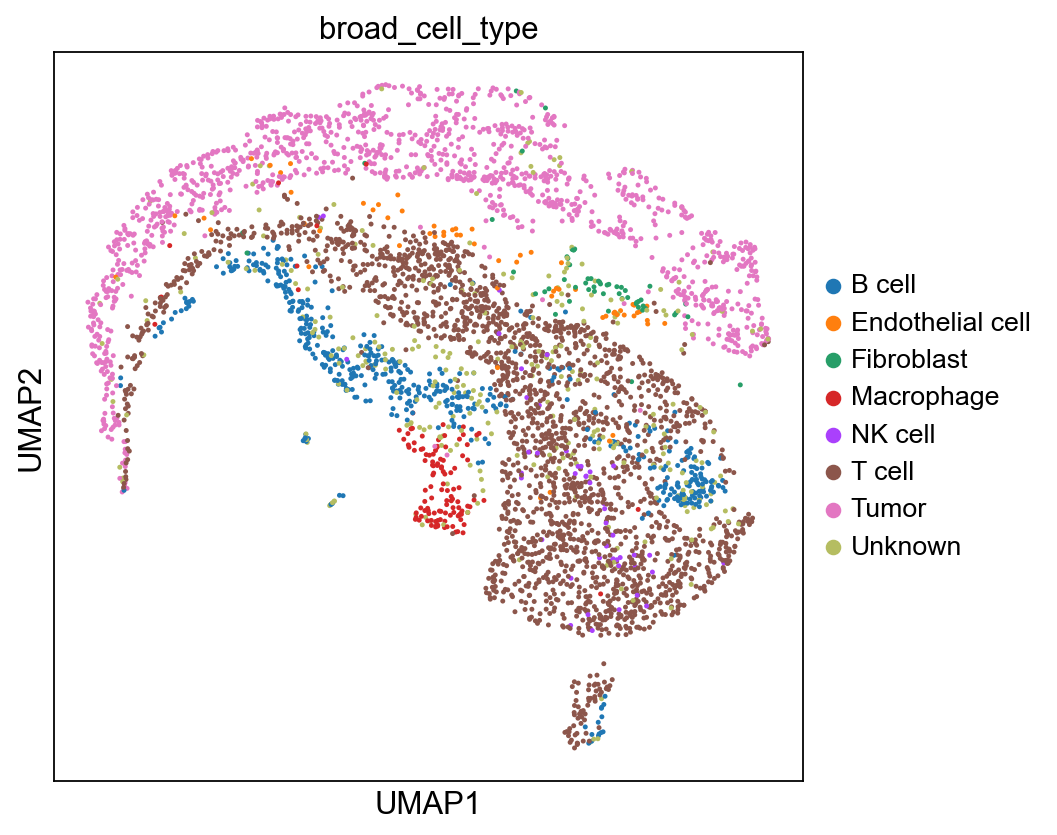

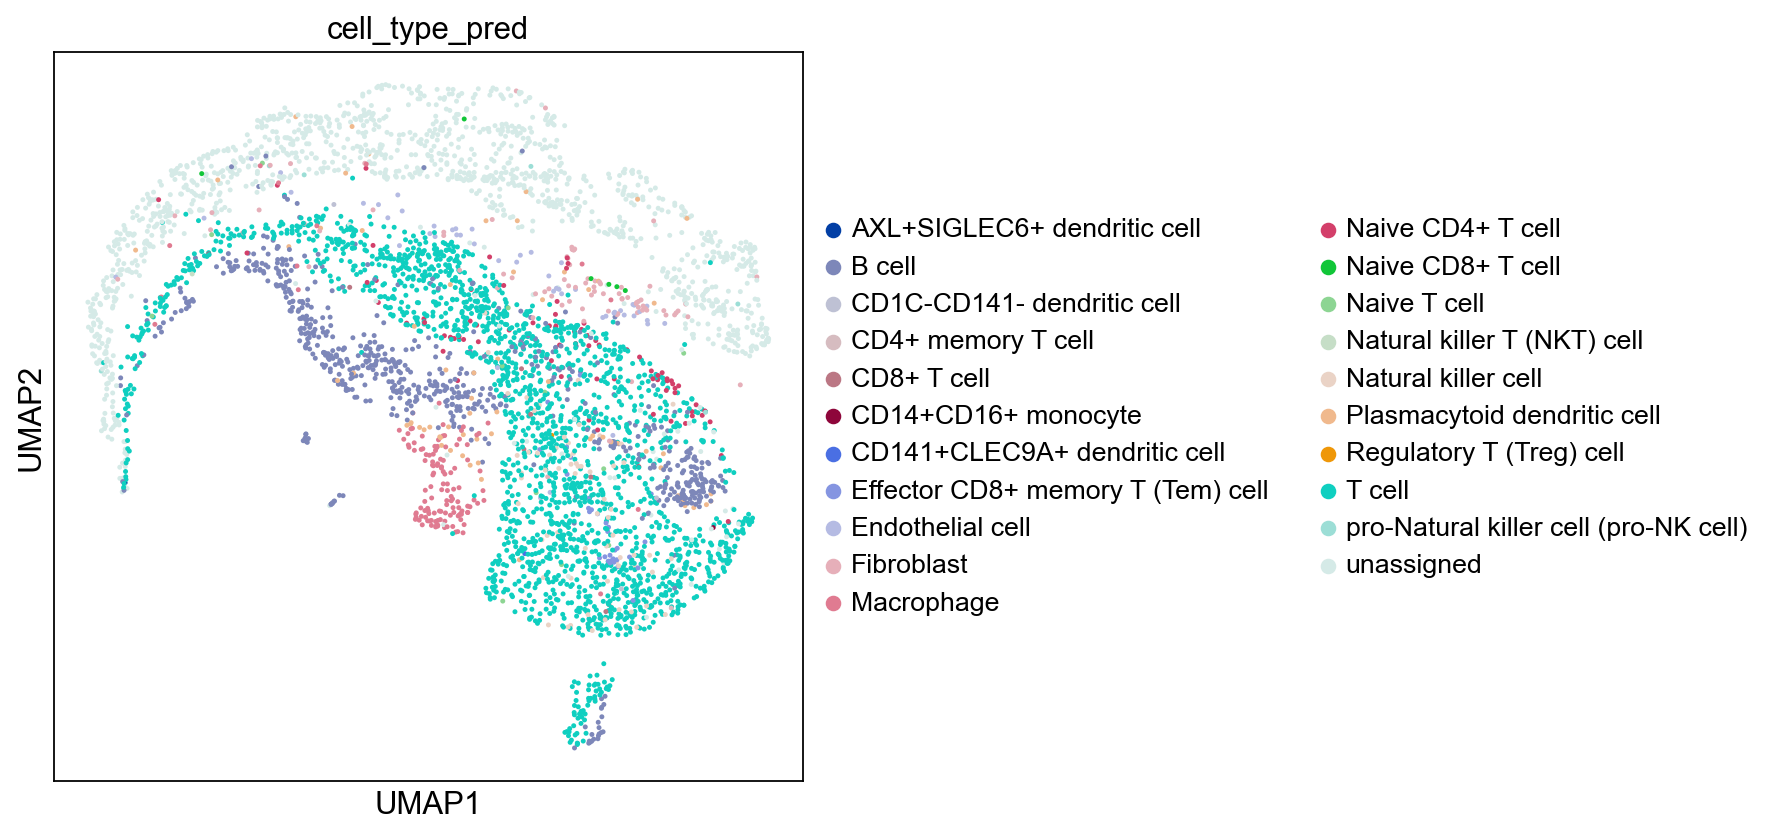

In [24]:
import scanpy as sc

#PCA
N_pca = 15
sc.tl.pca(adata_test, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(adata_test, n_neighbors=10, n_pcs=N_pca)
sc.tl.umap(adata_test)

sc.settings.verbosity = 3
sc.settings.set_figure_params(figsize=(6, 6), dpi=80, facecolor='white')

sc.pl.umap(adata_test, color=['broad_cell_type'], s = 20, legend_fontsize = 12)
sc.pl.umap(adata_test, color=['cell_type_pred'], s = 20, legend_fontsize = 12)